# Classifying Social Media Posts as Hateful using NLP.

![Image: image from Star Trek Stands With Our AAPI Community](startrekpeace.JPG "image from Star Trek Stands With Our AAPI Community")

Say you are going through your favorite Scifi social network _Trekked-out_, and you are getting blasted with violent posts, shared to your timeline or worse getting tagged. 
Now as a peaceful Trekky, you don't want to experience this but the said platform has double-standards to its community guidelines and will not go against it's Starfleet or Romulan overlords.  

So you need to go _rogue_ and take action with the power of NLP. 

In this article, we will collect a set of polarizing posts, scraped from these platforms or provided pubicly in datasets, and train NLP models to recognize these violent posts. 

# The NLP Frameworks: spaCY and Sktlearn

SktLearn is a set of simple and efficient tools for predictive data analysis built on NumPy, SciPy, and matplotlib. Luckily for us its Open source.

SpaCy also is free and opensource, and is usually used for its simplicity and documentation (given we aren't datascientists yet). 

Generally you'd want to use these frameworks to process large bodies of text (aka corpora), with the intention of:
- Understanding what do the words mean in given context?
- Who is doing what to whom?
- What organizations and products are mentioned in the text? 

# Training with Datasets

We will use a public dataset curated by [HuggingFace](https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speechWe), consisting of 39k comments annotated by 7k annotators. The annotators tried to rank toxic these social media posts are. 

The dataset classifies the *text* as follows (with scores):
- insult - 0-4, how serious the insult is.
- humiliate - 0-4, the humiliation how strong.
- dehumanize - 0-4.
- violence - 0-4, how serious the violence is suggested. We will be looking closely at this.
- genocide - 0-4, any references to race killing.
- hatespeech - General hate sintmient. 0-2 (why not 4? That is what the dataset annotators decided).

In preprocessing, we will  normalize these scores to either 1 or 0 (it's violent or not).



In [31]:
# Pip below for Kaggle and online notebooks (should be done in production).
!pip install ipywidgets
!pip install datasets
!pip install swifter
!pip install sklearn

import datasets 
import pandas as pd
import numpy as np

dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
df = dataset['train'].to_pandas()

# Training NLP Pipelines

An NLP pipeline has these basic steps:

1. Cleaning - which we have done already on the corpus.
2. Tokenization - Break down of words at points of speech.
3. Vectorization - Convert the words into scalar numbers.
4. Classification - Associate our word vectors with a label to allow prediction to happen.

Or as illustrated below:

![NLP Pipeline.jpg](NLP%20Pipeline.jpg)

Both Spacy and SKT pipelines come ready with components or out-of-the-box pipelines to carry these out. 

We start with the text preprocessing to clean this up.
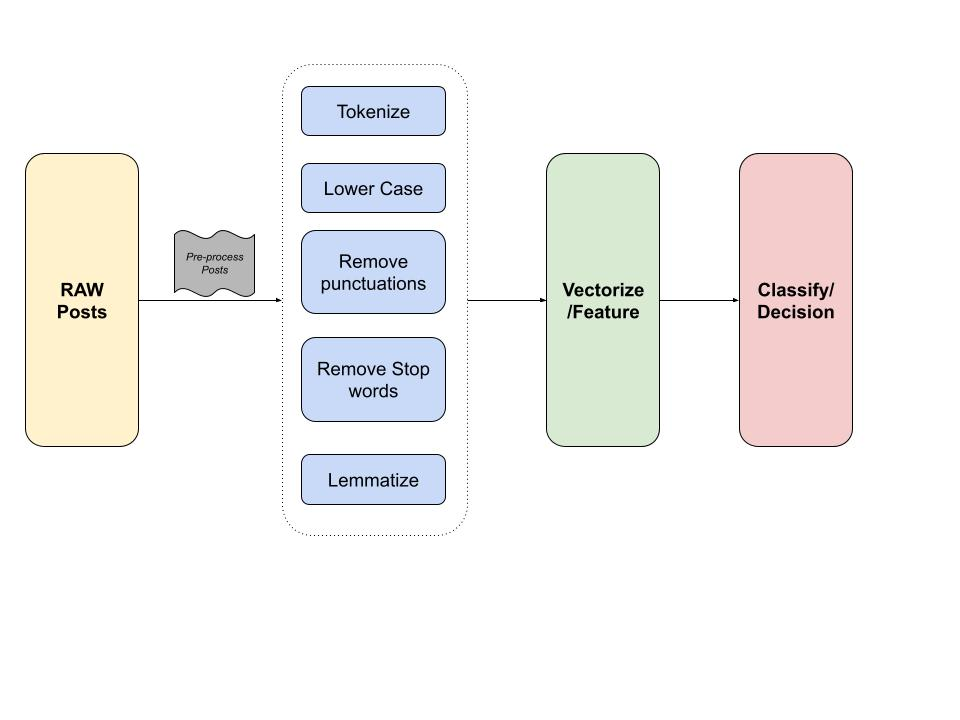

In [32]:
!pip install nltk
import nltk
nltk.download('wordnet')

import string
import pandas as pd
import swifter
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize

stopwords = stopwords.words('english')
punctuation = string.punctuation

categories = ['hatespeech', 'insult', 'violence', 'genocide']

def clean_text(text):
    clean_text = text.lower()
    clean_text = " ".join(x for x in clean_text.split() if x not in stopwords and x not in punctuation)
    clean_text = " ".join(lemmatizer.lemmatize(x) for x in clean_text.split())

    return clean_text

print("Preprocessing text")

df = df[['hatespeech', 'insult', 'violence', 'genocide', 'text']]
df = df.dropna()

df['clean_text'] = df['text'].swifter.apply(lambda x: clean_text(x))

print("Reducing text's features")
df['hatespeech'] = df['hatespeech'].swifter.apply(lambda x: 0 if x <= 1 else 1)
df['insult'] = df['insult'].swifter.apply(lambda x: 0 if x <= 1 else 1)
df['violence'] = df['violence'].swifter.apply(lambda x: 0 if x <= 1 else 1)
df['genocide'] = df['genocide'].swifter.apply(lambda x: 0 if x <= 1 else 1)

df.describe()

Followed by the training pipelines.

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.base import clone

import warnings
warnings.simplefilter('ignore')

rfc = RandomForestClassifier(n_estimators = 500, criterion = "gini", max_depth = 10,
                             max_features = "auto", min_samples_leaf = 0.005,
                             min_samples_split = 0.005, n_jobs = -1)
sgdc = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, 
                     max_iter=15, tol=None, verbose=False)

bow_vector = CountVectorizer(ngram_range = (1,1), stop_words='english')

estimators = [('sgdc', sgdc), ('rfc', rfc)]
sclf = StackingClassifier(estimators = estimators)

nlp_pipeline = Pipeline([('vectorizer', bow_vector), ('classifier', sclf)])

grid = dict()
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2)
categories = ['hatespeech', 'insult', 'violence', 'genocide']
train, test = train_test_split(df, test_size=0.35)
search = GridSearchCV(nlp_pipeline, grid, n_jobs=-1, cv=cv)

models = []
for category in categories:
    print(f'Processing classifier for {category}')
    
    search_clone = clone(search)
    search_clone.fit(train['clean_text'],  train[category])
    
    model ={}
    model['category'] = category
    model['model'] = search_clone
    models.append(model)
    
    prediction = search_clone.predict(test['clean_text'])
    print(f'Processed with accuracy_score {accuracy_score(test[category], prediction)}\n')

Now let's test out our trained models on some intergalatic posts, will these be Vulcan in nature (neutral and logical) or plain-old toxic?

![Image: image from tcvnews.tv](hatebanner.jpg "image from tcvnews.tv")

In [42]:
import json

f = open('warposts.json')
posts = json.load(f)['posts']
f.close()

sample_text1 = posts[1]
sample_text2 = posts[5]

for model in models:
    model, category = model['model'], model['category']
    
    prediction = model.predict([clean_text(sample_text1)])
    print(f'category: {category}, predicted: {prediction} for:\n {sample_text1}\n')
    
    prediction = model.predict([clean_text(sample_text2)])
    print(f'category: {category}, predicted {prediction} for:\n {sample_text2}\n\n')

# Applying Named Entity Recognition (NER)

Using spacy, we will look into the posts and see if these have specific entities worth noting. 
With NER we can identify the following:

| **Category**                              | **Description**                                      |
| ----------------------------------------- | ---------------------------------------------------- |
| PERSON:                                   | People, including fictional.                         |
| NORP:                                     | Nationalities or religious or political groups.      |
| FAC:                                      | Buildings, airports, highways, bridges, etc.         |
| ORG:                                      | Companies, agencies, institutions, etc.              |
| GPE:                                      | Countries, cities, states.                           |
| PRODUCT:                                  | Objects, vehicles, foods, etc. (Not services.)       |
| EVENT:                                    | Named hurricanes, battles, wars, sports events, etc. |
| WORK_OF_ART:                              | Titles of books, songs, etc.                         |
| LAW:                                      | Named documents made into laws.                      |
| DATE:                                     | Absolute or relative dates or periods.               |
| TIME:                                     | Times smaller than a day.                            |

To have NER, spacy first needs to download and load its english pipelines, as show below.

In [43]:
! pip install spacy
import spacy
from spacy import displacy

spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

With the pipeline ready and available, we can provide some hints in the form of label patterns to add more classifications the NER ouput.

Once we know what to label (in addition to the default categories Spacy offers), we can execute the pipeline on the text and analyze it. Below you can see how Spacy outline entities within the text.

In [45]:
pattern=["space battle", "evil agenda", "genocide", "#EvilMonarchs", "facist", "Red Matter", "Borg Cubes",  \
        "Klingon invasion", "Romulan invasions", "invasions", "Galatic War", "Kahless the Unforgettable"]

#Create or replace the EntityRuler
if nlp.has_pipe("entity_ruler") and nlp.get_pipe("entity_ruler") is not None:
    nlp.remove_pipe("entity_ruler")

ruler = nlp.add_pipe("entity_ruler", first=True)
for a in pattern:
    ruler.add_patterns([{"label": "GALATIC_WAR", "pattern": a}])
    
sample_doc1 = nlp(sample_text1)
sample_doc2 = nlp(sample_text2)

displacy.render(sample_doc1, style="ent", jupyter=True)

# Concluding our Analysis

We trained models to identify how toxic posts are and we used Spacy to find who is doing these and at who.

With this automated knowledge, we have the power to affect changes to our feed and more. Live long and Prosper!

# References

- https://huggingface.co/datasets/ucberkeley-dlab/measuring-hate-speechWe 
- https://scikit-learn.org/stable
- https://spacy.io
- https://intl.startrek.com/news/star-trek-stands-with-our-aapi-community

## Github and Kaggle

Article here is also available on [Github](https://github.com/adamd1985/articles/tree/main/nlp_intro) and [Kaggle](https://www.kaggle.com/code/addarm/classifying-social-media-posts-as-hateful-nlp/notebook)

#
<div align="right">Made with :heartpulse: by <b>Adam</b></div>